In [131]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt


In [132]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [133]:
# Hyperparameters
num_epochs = 10
learning_rate = 0.01
batch_size = 64

In [134]:
def get_transforms() -> torchvision.transforms:
    return torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         # torchvision.transforms.Normalize([0.5], [0.5])
        ]
    )


In [135]:
def show_tensor_imgs(imgs, nrows=8):
    print(imgs.shape)
    grid_image = torchvision.utils.make_grid(imgs, nrows)
    print(grid_image.shape)
    plt.imshow(grid_image.permute(1,2,0))
    


In [136]:
def show_orig_vs_recon(orig_batch, recon_batch):
    fig, axs = plt.subplots(2, 8, figsize=(20, 5))
    for j in range(8):
        axs[0][j].imshow(orig_batch[j].permute(1, 2, 0))
        axs[1][j].imshow(recon_batch[j].permute(1, 2, 0))
    plt.axis('off')
    plt.show()


In [137]:
train_ds = torchvision.datasets.FashionMNIST(root='../../data', train=True, download=True, transform=get_transforms())
test_ds = torchvision.datasets.FashionMNIST(root='../../data', transform=get_transforms()) 

train_dl = torch.utils.data.DataLoader(train_ds, shuffle=True, batch_size=batch_size)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

torch.Size([4, 1, 28, 28])
torch.Size([3, 32, 122])


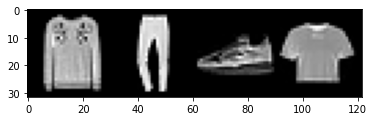

In [138]:
samples, labels = iter(train_dl).next()
show_tensor_imgs(samples[0:4])

In [139]:
class CnnAutoEncoder(nn.Module):
    """ A convolution based autoencoder implementation.

    The decoder is an exact mirror of the encoder.
    The last layer of the decoder uses sigmoid to output images in
    0 to 1 range
    """

    def __init__(self):
        super(CnnAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, 5),  # output -> 6, 24, 24
            nn.ReLU(),
            nn.Conv2d(6, 16, 5, stride=2), # output -> 16, 10, 10
            nn.ReLU(),
            nn.Conv2d(16, 24, 5, stride=2),  # output -> 24, 3, 3
            nn.ReLU(),
            nn.Conv2d(24, 36, 3),  # output -> 36, 1, 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(36, 24, 3),  # output -> 24, 3, 3
            nn.ReLU(),
            nn.ConvTranspose2d(24, 16, 5, stride=2, output_padding=1),  # output -> 16, 10, 10
            nn.ReLU(),
            nn.ConvTranspose2d(16, 6, 5, stride=2, output_padding=1),  # output -> 6, 24, 24
            nn.ReLU(),
            nn.ConvTranspose2d(6, 1, 5), # output -> 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_vec = self.encoder(x)
        reconstructed = self.decoder(latent_vec)
        return reconstructed


In [140]:
model = CnnAutoEncoder().to(device)
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)




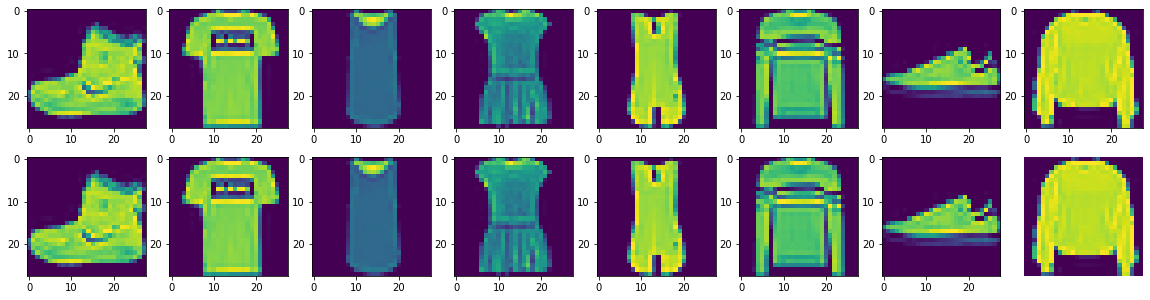

In [141]:
orig_batch, _ = iter(test_dl).next()
show_orig_vs_recon(orig_batch[0:8], orig_batch[0:8])

In [142]:
def apply_on_test_batch(model, epoch):
    orig_batch, _ = iter(test_dl).next()
    with torch.no_grad():
        orig_batch.to(device)
        recon_batch = model(orig_batch)
        orig_batch.detach()
        recon_batch.detach()
        print(f'Epoch {epoch}, Orignal vs Reconstructed')
        show_orig_vs_recon(orig_batch[0:8], recon_batch[0:8])

Epoch 0, Orignal vs Reconstructed


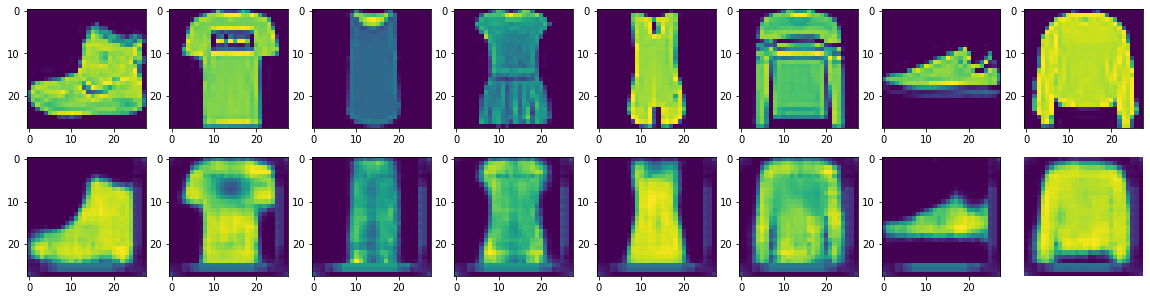

Epoch 1, Orignal vs Reconstructed


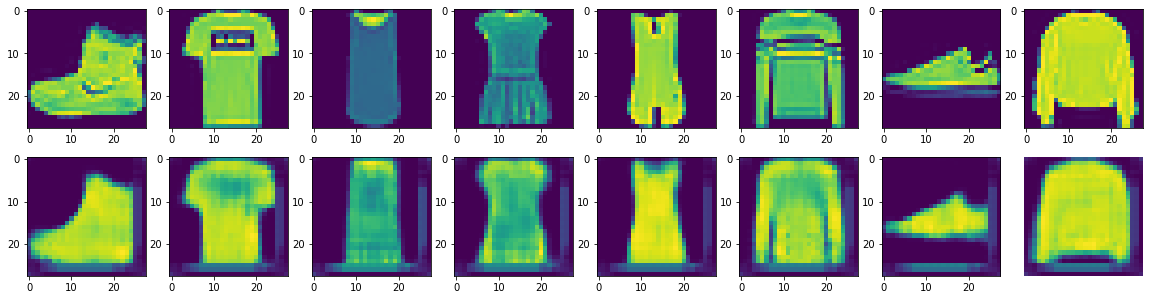

Epoch 2, Orignal vs Reconstructed


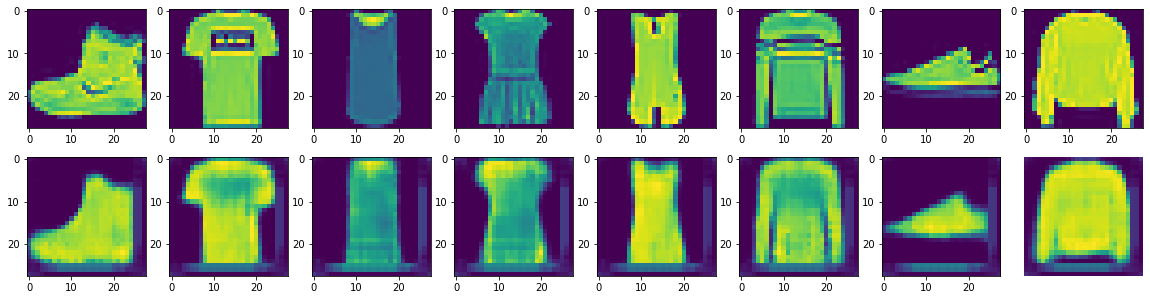

Epoch 3, Orignal vs Reconstructed


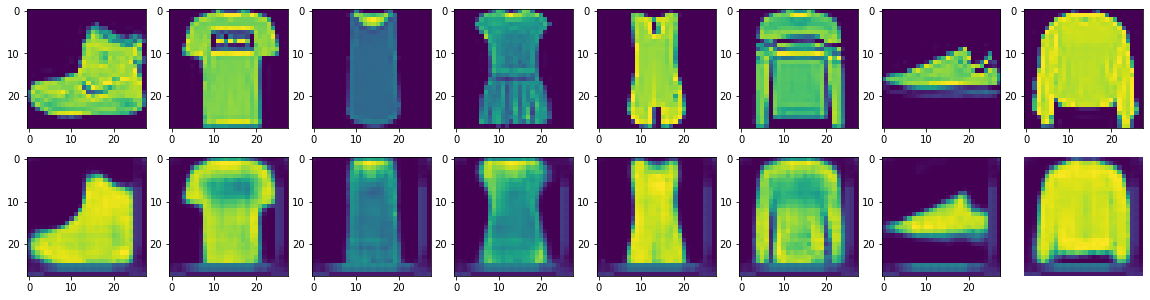

Epoch 4, Orignal vs Reconstructed


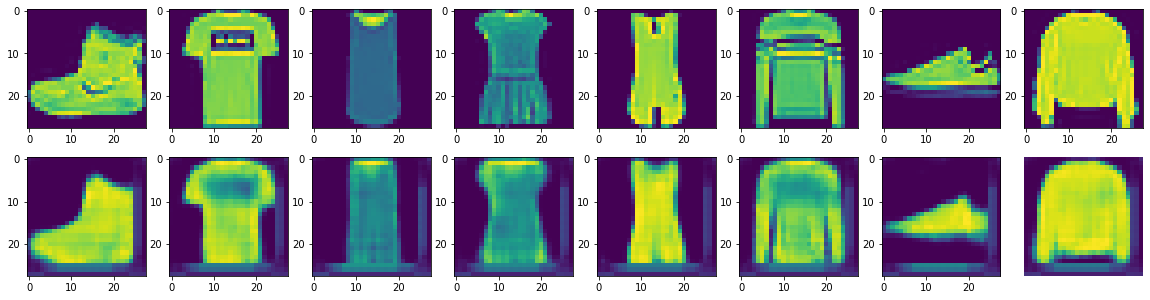

Epoch 5, Orignal vs Reconstructed


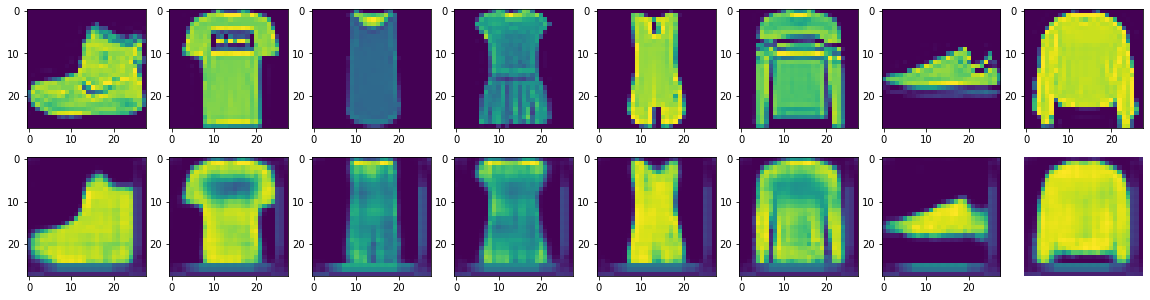

Epoch 6, Orignal vs Reconstructed


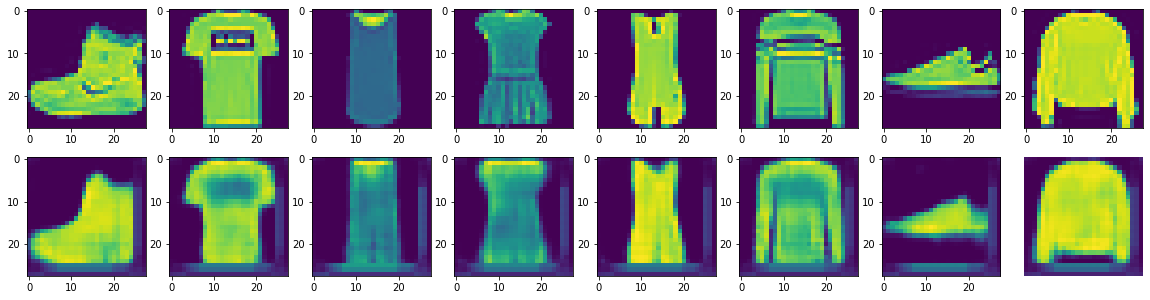

Epoch 7, Orignal vs Reconstructed


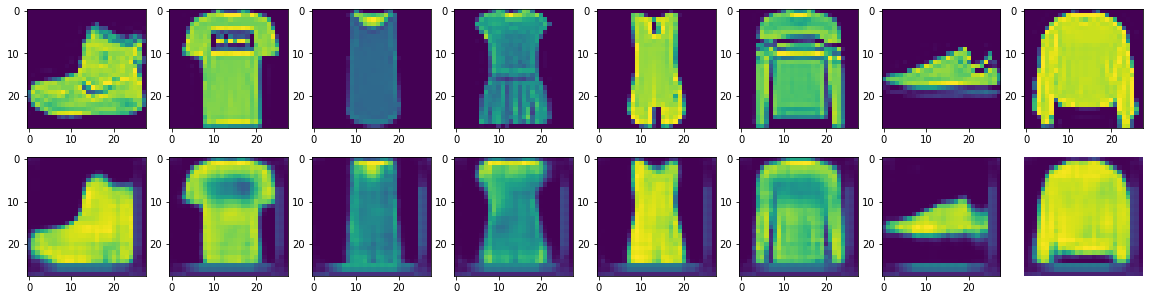

Epoch 8, Orignal vs Reconstructed


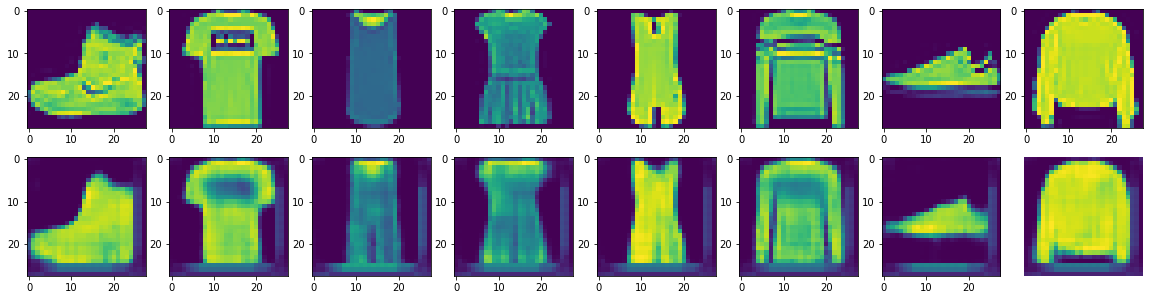

Epoch 9, Orignal vs Reconstructed


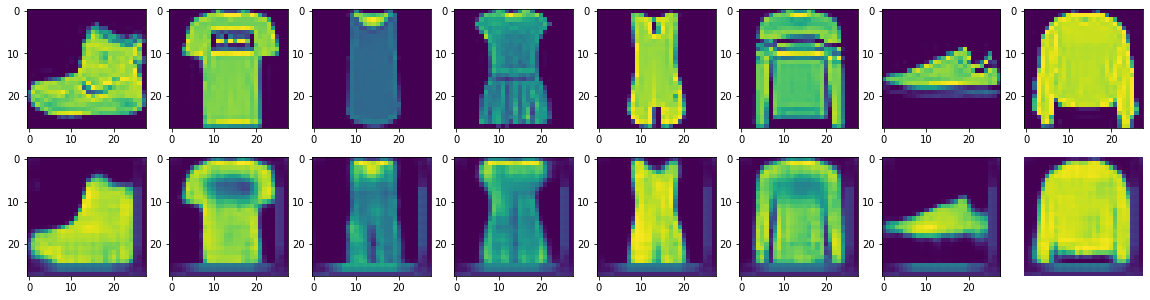

In [143]:

for epoch in range(num_epochs):
    for i, (samples, labels) in enumerate(test_dl):
        orig = samples.to(device)
        reconstructed = model(orig)
        loss = criterion(reconstructed, orig)
        optim.zero_grad()
        loss.backward()
        optim.step()

        if (i+1 % 100 == 0):
            print(f'epoch {epoch + 1} / num_epoch {num_epochs}, step {epoch * batch_size + i + 1}, loss = {loss.item():.4f} ')
    
    apply_on_test_batch(model, epoch)
    

    

    